# 3W Dataset Processing & Scaling Methods

Data preprocessing for the 3W dataset - fault detection in oil wells.

## Processing Steps
- Data loading with optional sampling
- Multiple scaling methods comparison  
- Cross-validation with real/simulated separation
- Time windowing for sequence models
- Data persistence for training notebooks

## Configuration
All parameters managed in `src/config.py`

In [1]:
# Import and Validate Configuration
import os
from src import DataLoader, DataPreprocessor, DataVisualizer, CrossValidator
from src import config

# Validate configuration
config_warnings = config.validate_config()
if config_warnings:
    print("⚠️ Configuration Warnings:")
    for warning in config_warnings:
        print(f"   • {warning}")
    print()

print("🚀 3W Dataset Processing Methods Loaded")
print(f"📋 Configuration: Target features: {len(config.TARGET_FEATURES)}, "
      f"Scaling: {config.DEFAULT_SCALING_METHOD}, "
      f"CV folds: {config.N_FOLDS}, "
      f"Window: {config.WINDOW_SIZE}")
if config.ENABLE_DATA_SAMPLING:
    print(f"📊 Data sampling: 1/{config.SAMPLING_RATE} ({config.SAMPLING_METHOD})")
print(f"🎲 Random seed: {config.RANDOM_SEED}")

🚀 3W Dataset Processing Methods Loaded
📋 Configuration: Target features: 4, Scaling: minmax, CV folds: 3, Window: 300
📊 Data sampling: 1/5 (uniform)
🎲 Random seed: 42


📁 Dataset Structure:
Class 0: 594 parquet files
  └── Real data: 594 files
  └── Simulated data: 0 files

Class 1: 128 parquet files
  └── Real data: 4 files
  └── Simulated data: 124 files

Class 2: 38 parquet files
  └── Real data: 22 files
  └── Simulated data: 16 files

Class 3: 106 parquet files
  └── Real data: 32 files
  └── Simulated data: 74 files

Class 4: 343 parquet files
  └── Real data: 343 files
  └── Simulated data: 0 files

Class 5: 450 parquet files
  └── Real data: 11 files
  └── Simulated data: 439 files

Class 6: 221 parquet files
  └── Real data: 6 files
  └── Simulated data: 215 files

Class 7: 46 parquet files
  └── Real data: 36 files
  └── Simulated data: 10 files

Class 8: 95 parquet files
  └── Real data: 14 files
  └── Simulated data: 81 files

Class 9: 207 parquet files
  └── Real data: 57 files
  └── Simulated data: 150 files

Total classes found: 10
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
📊 Loading 10 classes
🔄 Loading 3W Dataset...
C

Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Debug - File: WELL-00001_20170201010207.parquet
  Shape: (21474, 29)
  Columns: ['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2', 'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2', 'ESTADO-XO', 'P-ANULAR', 'P-JUS-BS', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKGL', 'P-MON-CKP', 'P-MON-SDV-P', 'P-PDG', 'PT-P', 'P-TPT', 'QBS', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT', 'class', 'state']
  Has 'class' column: True
  Sampling: 17874 → 3575 samples (1/5)
  ✅ Successfully loaded: 3575 samples
Debug - File: WELL-00001_20170201060114.parquet
  Shape: (21527, 29)
  Columns: ['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2', 'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2', 'ESTADO-XO', 'P-ANULAR', 'P-JUS-BS', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKGL', 'P-MON-CKP', 'P-MON-SDV-P', 'P-PDG', 'PT-P', 'P-TPT', 'QBS', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT', 'class', 'state']
  Has 'class' column: True
  Sampling: 1

Processing classes: 100%|██████████| 10/10 [01:55<00:00, 11.59s/it]




📊 Loading Summary:
Total files processed: 2228
Successfully loaded: 2228 files
Real data files: 1119
Simulated data files: 1109
Empty/invalid files: 0
Total samples: 14,512,424
✅ Dataset loaded: 2228 dataframes, 10 unique classes
📈 Class distribution: {'0': 594, '1': 128, '2': 38, '3': 106, '4': 343, '5': 450, '6': 221, '7': 46, '8': 95, '9': 207}
🔍 Dataset Analysis
Total number of dataframes: 2228
Class distribution: Counter({'0': 594, '5': 450, '4': 343, '6': 221, '9': 207, '1': 128, '3': 106, '8': 95, '7': 46, '2': 38})


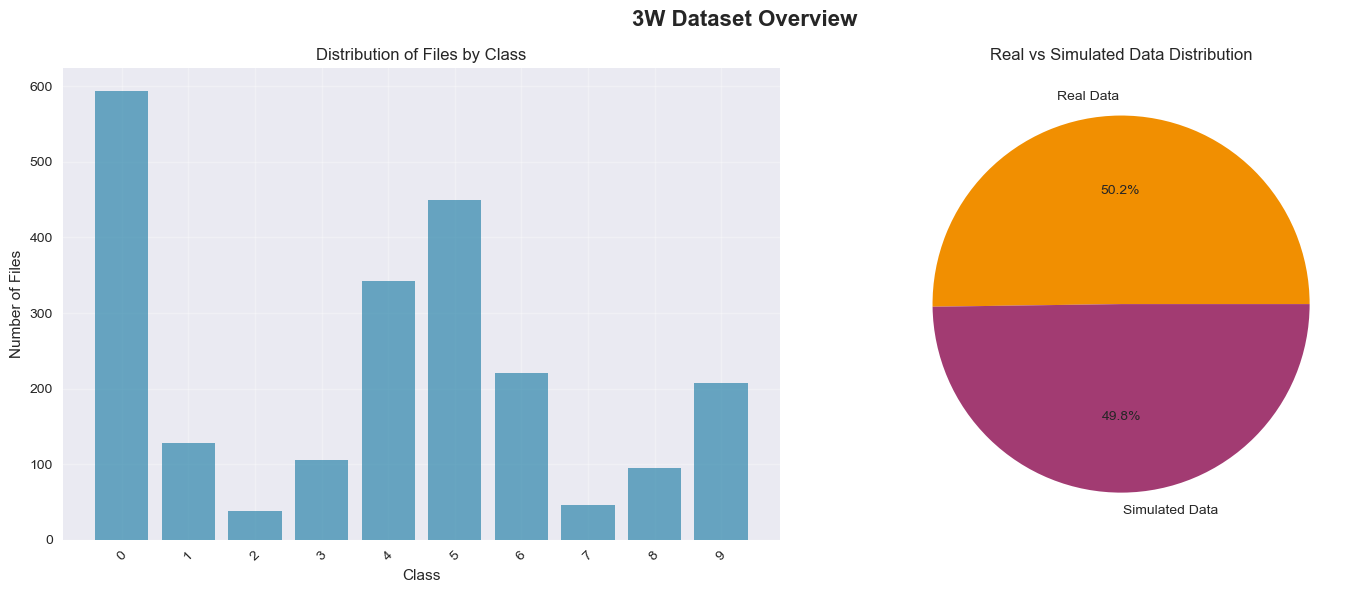

\n💾 Total samples: 14,512,424


In [2]:
# Step 1: Load and Explore Dataset
from collections import Counter

try:
    # Initialize components
    loader = DataLoader()
    preprocessor = DataPreprocessor()
    visualizer = DataVisualizer()

    # Explore and load dataset
    structure_info = loader.explore_structure()
    available_classes = structure_info.get("classes", [])
    
    print(f"📊 Loading {len(available_classes)} classes")
    dfs_all, classes_all, stats_all = loader.load_dataset(available_classes)

    # Store data
    dfs = dfs_all
    classes = classes_all
    stats = stats_all

    print(f"✅ Dataset loaded: {len(dfs)} dataframes, {len(set(classes))} unique classes")
    print(f"📈 Class distribution: {dict(Counter(classes))}")

    # Show overview
    visualizer.plot_dataset_overview(classes, stats)

except Exception as e:
    print(f"❌ Dataset loading failed: {str(e)}")
    print("🔧 Please check dataset path and structure")
    dfs, classes, stats = [], [], {}

## Dataset Loading

Load the 3W dataset and explore structure.

In [3]:
# Step 2: Filter to Key Sensor Features
print("🔍 Step 2: Filtering Key Features")
print("=" * config.SEPARATOR_LENGTH)

# Focus on pressure and temperature sensors using config
target_features = config.TARGET_FEATURES
filtered_dfs, filtered_classes = loader.filter_target_features(
    dfs, classes, target_features
)

print(f"✅ Filtered to {len(filtered_dfs)} dataframes with key sensor data")
print(f"📋 Target features from config: {target_features}")

# Get dataset information
dataset_info = loader.get_dataset_info(filtered_dfs, filtered_classes)
print(f"\n📋 Dataset Summary:")
for key, value in dataset_info.items():
    print(f"   {key}: {value}")

🔍 Step 2: Filtering Key Features
🔍 Filtering Data to Key Sensor Variables
Target features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']

📄 DataFrame 1 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3575, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 2 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3586, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 3 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3584, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📊 Filtering Results:
Datasets after filtering: 1714
Total samples: 11,750,631

🎯 Feature Availability Across Datasets:
----------------------------------------
P-PDG: 1714/1714 dataset

## Feature Filtering

Filter dataset to target sensor variables.

📈 Step 3: Raw Data Analysis
🎯 Selected: DataFrame 1310, Class 5
   Sample size: 5860 data points
   Using config: min_samples=100
\n🔸 Plotting Raw Data Analysis...
🎯 Selected: DataFrame 1310, Class 5
   Sample size: 5860 data points
   Using config: min_samples=100
\n🔸 Plotting Raw Data Analysis...


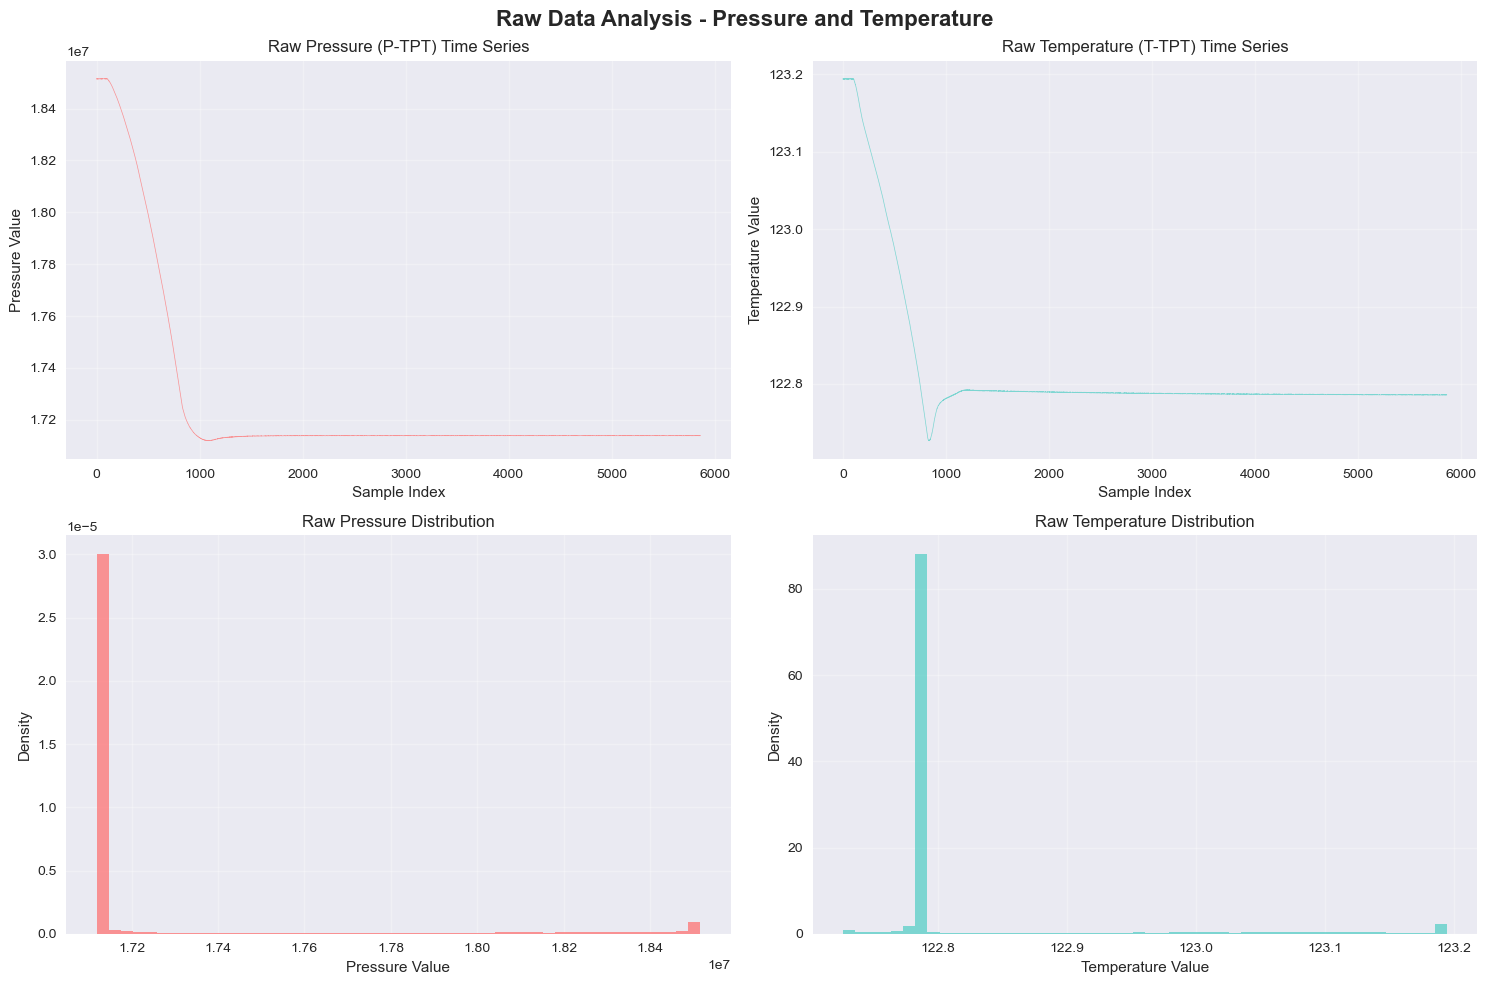

\n📈 Data Statistics:
Shape: (5860, 2)
              P-TPT        T-TPT
count  5.860000e+03  5860.000000
mean   1.727027e+07   122.818200
std    3.546167e+05     0.093966
min    1.711926e+07   122.726594
25%    1.713844e+07   122.786295
50%    1.713867e+07   122.787421
75%    1.713929e+07   122.789897
max    1.851547e+07   123.194481


In [4]:
# Step 3: Raw Data Analysis
print("📈 Step 3: Raw Data Analysis")
print("=" * config.SEPARATOR_LENGTH)

# Select random sample for detailed analysis using config values
try:
    idx, sample_df, class_label, sample_count = preprocessor.select_random_dataframe(
        filtered_dfs,
        filtered_classes,
        required_columns=config.REQUIRED_COLUMNS,
        min_samples=config.SAMPLE_ANALYSIS_MIN_SAMPLES,
    )

    print(f"🎯 Selected: DataFrame {idx + 1}, Class {class_label}")
    print(f"   Sample size: {sample_count} data points")
    print(f"   Using config: min_samples={config.SAMPLE_ANALYSIS_MIN_SAMPLES}")

    # Plot raw data analysis using config column names
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

except ValueError as e:
    print(f"⚠️ {e}")
    print("Using first available dataframe...")
    sample_df = filtered_dfs[0]
    class_label = filtered_classes[0]
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

## Data Scaling Methods

Apply different scaling methods and compare results.

⚙️ Step 4: Scaling Methods Comparison
📊 Scaling Results:

StandardScaler:
  Pressure - Range: [-0.4259, 3.5117]
  Temperature - Range: [-0.9750, 4.0048]

MinmaxScaler:
  Pressure - Range: [0.0000, 1.0000]
  Temperature - Range: [0.0000, 1.0000]

RobustScaler:
  Pressure - Range: [-22.7704, 1614.9756]
  Temperature - Range: [-16.8867, 113.0068]

NormalizerScaler:
  Pressure - Range: [0.5752, 0.5786]
  Temperature - Range: [0.0000, 0.0000]
\n🔸 Plotting StandardScaler Analysis...


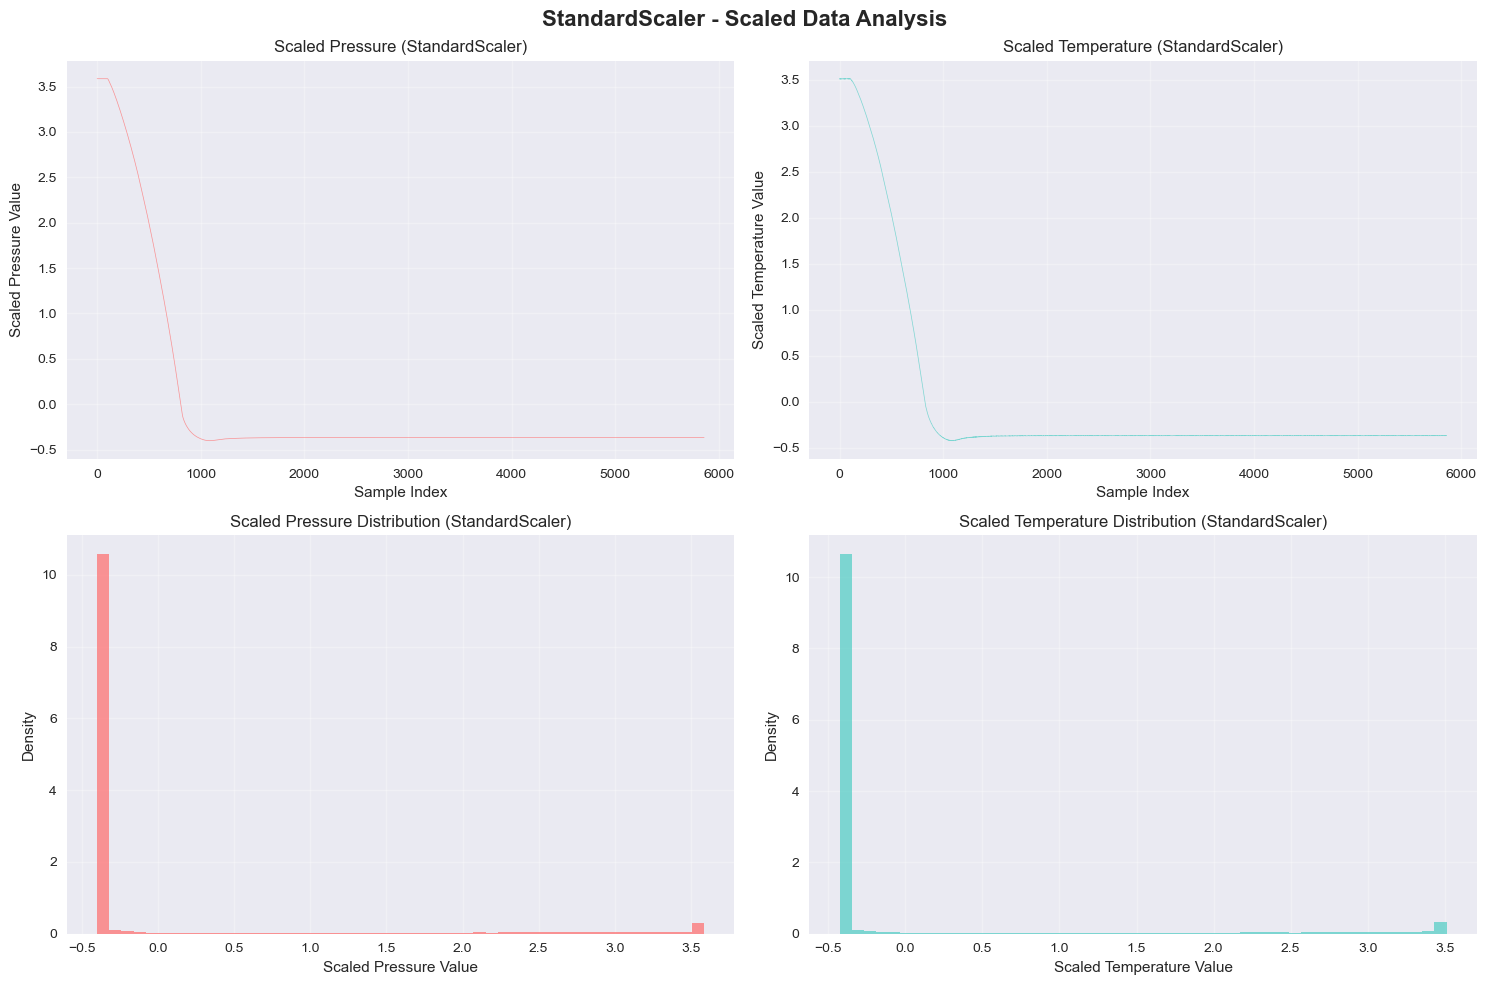

Statistics for StandardScaler:
Pressure - Mean: -0.0000, Std: 1.0001
Temperature - Mean: 0.0000, Std: 1.0001
\n🔸 Plotting MinmaxScaler Analysis...


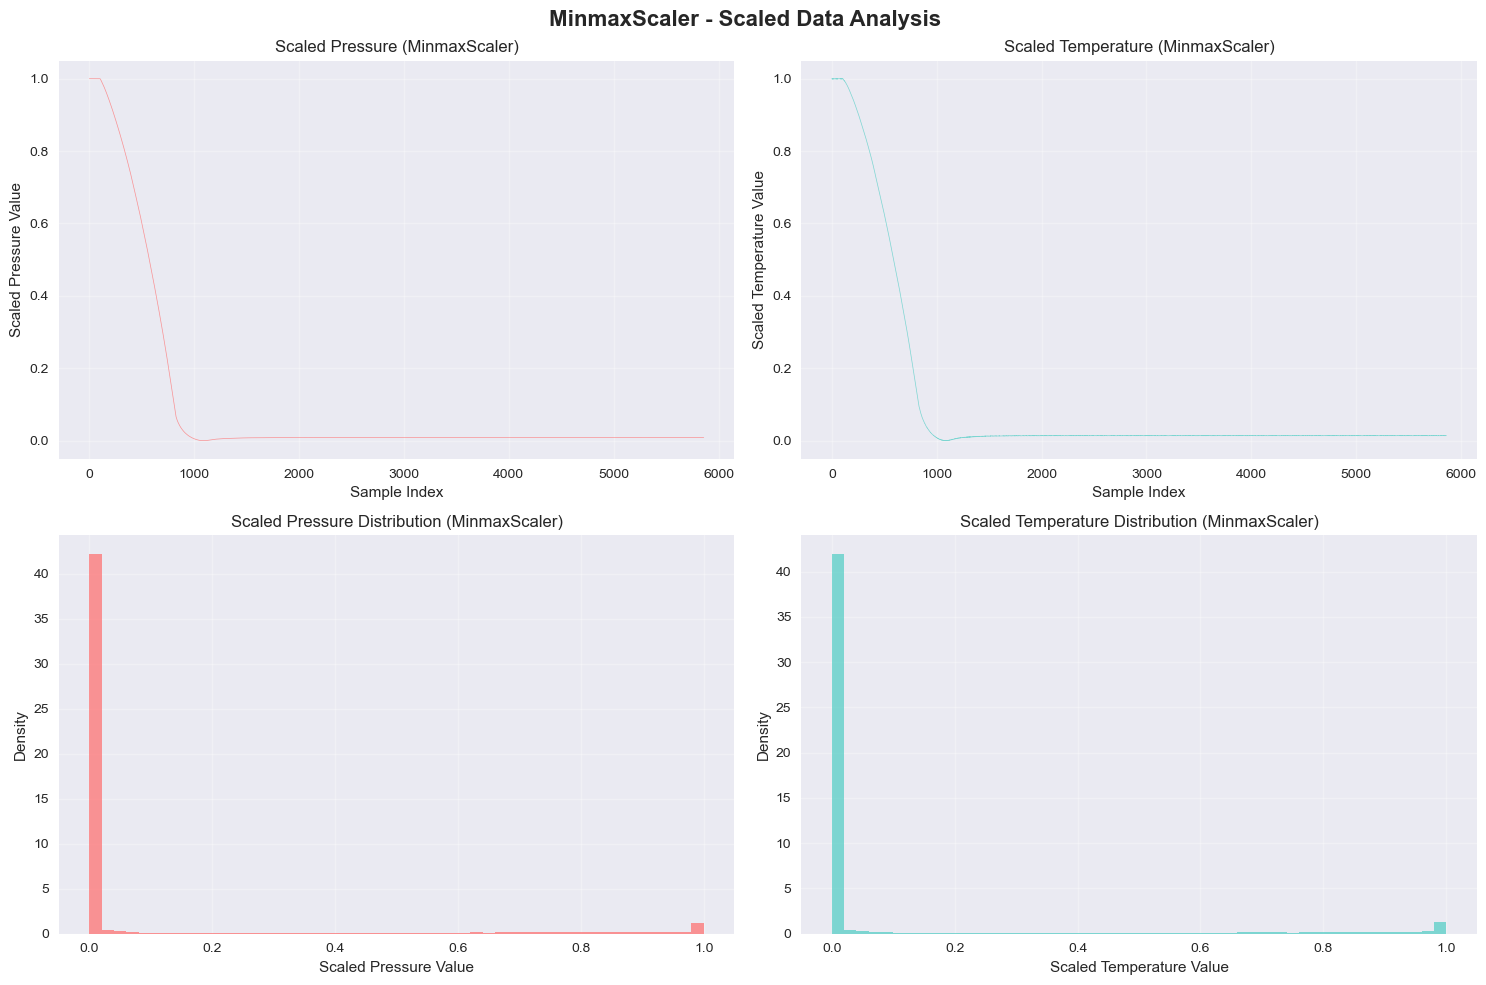

Statistics for MinmaxScaler:
Pressure - Mean: 0.1006, Std: 0.2507
Temperature - Mean: 0.1082, Std: 0.2540
\n🔸 Plotting RobustScaler Analysis...


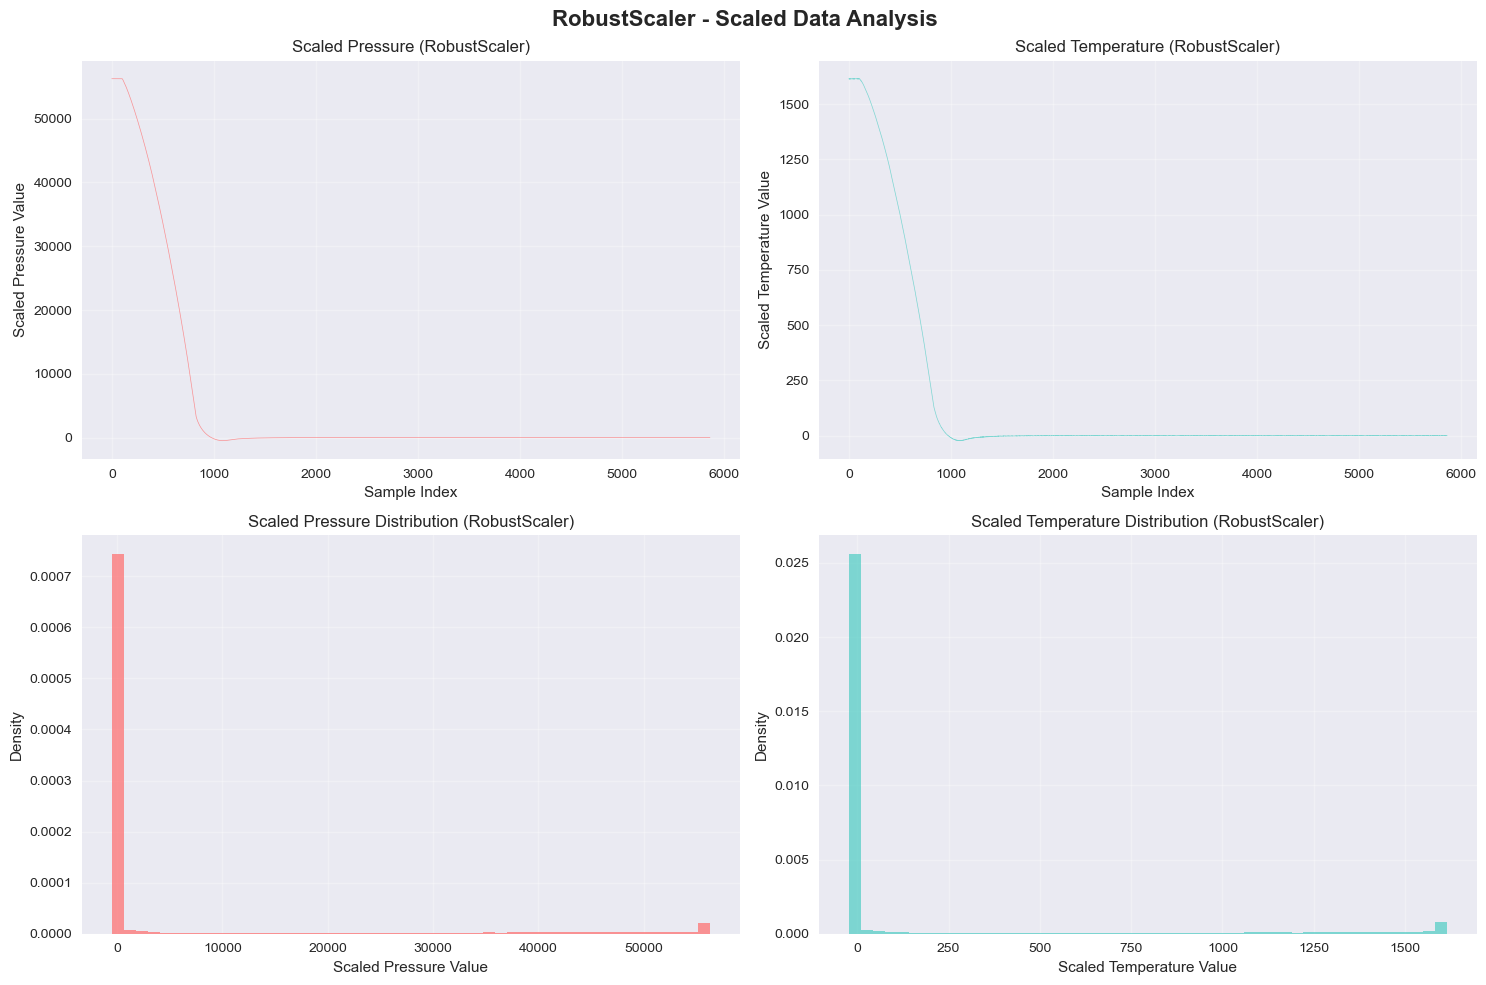

Statistics for RobustScaler:
Pressure - Mean: 5223.3117, Std: 14232.2194
Temperature - Mean: 154.3679, Std: 415.9616
\n🔸 Plotting NormalizerScaler Analysis...


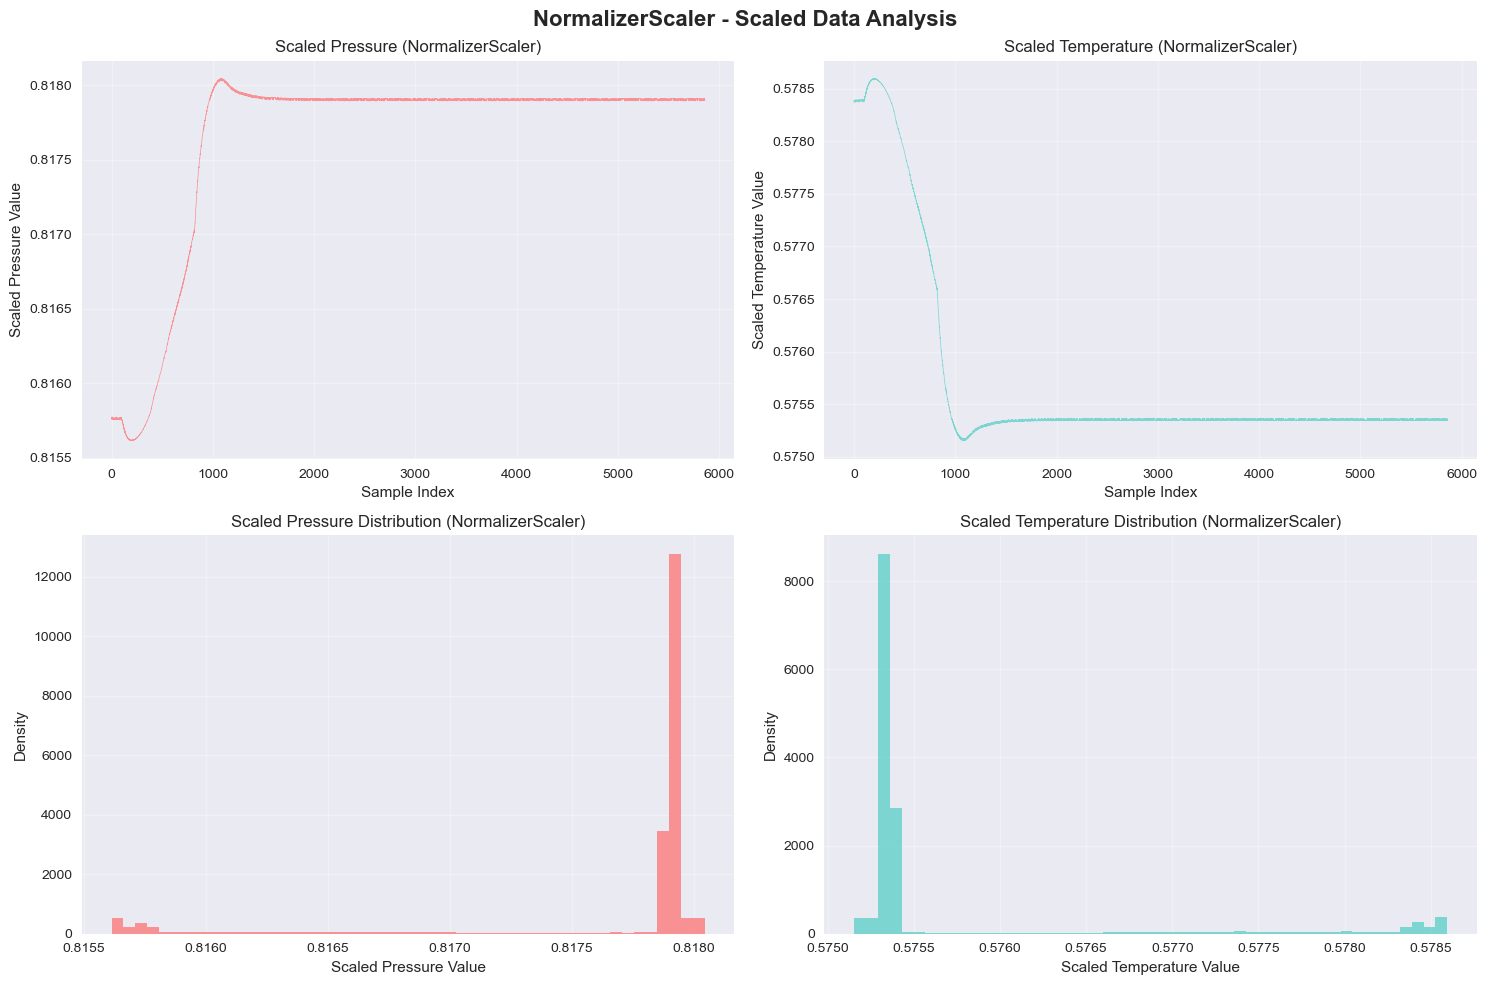

Statistics for NormalizerScaler:
Pressure - Mean: 0.8176, Std: 0.0007
Temperature - Mean: 0.5757, Std: 0.0009
\n🔸 Creating scaling comparison plots...


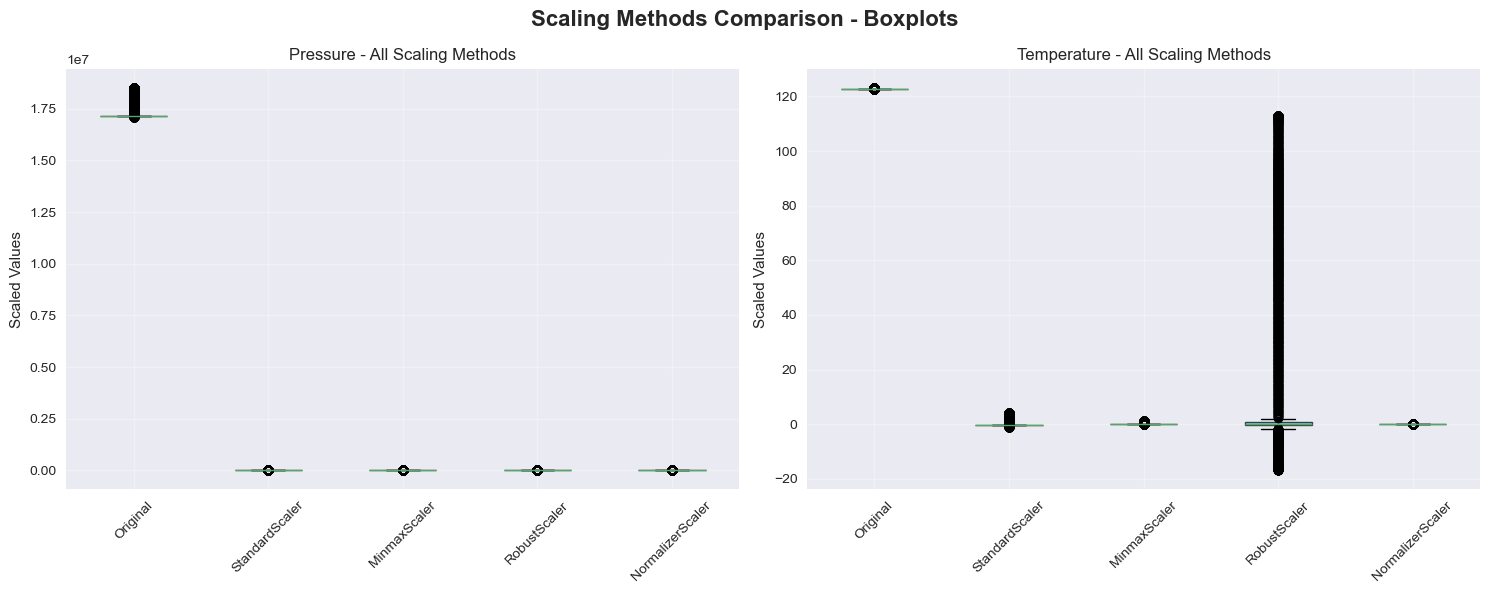

In [5]:
# Step 4: Scaling Methods Comparison
print("⚙️ Step 4: Scaling Methods Comparison")
print("=" * config.SEPARATOR_LENGTH)

# Apply all scaling methods to sample data
scaling_results = preprocessor.apply_multiple_scalers(sample_df)

# Display scaling statistics using config column names
print("📊 Scaling Results:")
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        numeric_cols = [
            col for col in scaled_data.columns if col != config.CLASS_COLUMN
        ]
        if numeric_cols:
            pressure_col = (
                [col for col in numeric_cols if config.PRESSURE_COLUMN in col][0]
                if any(config.PRESSURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[0]
            )
            temp_col = (
                [col for col in numeric_cols if config.TEMPERATURE_COLUMN in col][0]
                if any(config.TEMPERATURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]
            )

            print(f"\n{method_name}:")
            print(
                f"  Pressure - Range: [{scaled_data[pressure_col].min():.4f}, {scaled_data[pressure_col].max():.4f}]"
            )
            if pressure_col != temp_col:
                print(
                    f"  Temperature - Range: [{scaled_data[temp_col].min():.4f}, {scaled_data[temp_col].max():.4f}]"
                )

# Visualize each scaling method
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        visualizer.plot_scaled_data_analysis(scaled_data, method_name)

# Create comparison plot using config column names
visualizer.plot_scaling_comparison(
    scaling_results, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
)

## Apply Default Scaler

Apply configured scaling method to all data.

In [6]:
# Step 5: Apply MinMax Scaling to All Data
print("🔄 Step 5: Processing All Data with Configured Scaler")
print("=" * config.SEPARATOR_LENGTH)

# Apply scaling using config method
scaling_method = config.DEFAULT_SCALING_METHOD
print(f"📋 Using scaling method from config: {scaling_method}")

normalized_dfs, normalized_classes = preprocessor.apply_scaling(
    filtered_dfs, filtered_classes, method=scaling_method
)

# Validation
if normalized_dfs:
    sample_normalized = normalized_dfs[0]
    validation_results = preprocessor.validate_scaling(
        sample_normalized, scaling_method
    )

    print(f"\n✅ Successfully normalized {len(normalized_dfs)} dataframes")
    print(f"📊 Sample normalized data shape: {sample_normalized.shape}")
    print(
        f"🔍 Validation results: {all(validation_results['correct_scaling'].values())}"
    )
    print(f"⚙️ Scaling method applied: {scaling_method}")

    # Show sample of normalized data
    print(f"\n📋 Sample Normalized Data (first 3 rows):")
    print(sample_normalized.head(3))

    print(f"\n💾 Variables created:")
    print(f"   • normalized_dfs: {len(normalized_dfs)} normalized dataframes")
    print(f"   • normalized_classes: corresponding class labels")
    print(f"   • Scaling method: {scaling_method} (from config)")

else:
    print("❌ No data was successfully normalized")

🔄 Step 5: Processing All Data with Configured Scaler
📋 Using scaling method from config: minmax
🔄 Applying MinmaxScaler to All Dataframes
✅ DataFrame 1 (Class 0):
   Original shape: (3575, 4)
   Scaled shape: (3575, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 2 (Class 0):
   Original shape: (3586, 4)
   Scaled shape: (3586, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 3 (Class 0):
   Original shape: (3584, 4)
   Scaled shape: (3584, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 4 (Class 0):
   Origin


📊 Minmax Scaling Summary:
Total dataframes processed: 1714
Successfully scaled: 1714
Skipped (no data/errors): 0
Class distribution of scaled data: {np.str_('0'): np.int64(456), np.str_('1'): np.int64(128), np.str_('2'): np.int64(37), np.str_('3'): np.int64(106), np.str_('4'): np.int64(222), np.str_('5'): np.int64(450), np.str_('6'): np.int64(6), np.str_('7'): np.int64(41), np.str_('8'): np.int64(89), np.str_('9'): np.int64(179)}

✅ Successfully normalized 1714 dataframes
📊 Sample normalized data shape: (3575, 4)
🔍 Validation results: True
⚙️ Scaling method applied: minmax

📋 Sample Normalized Data (first 3 rows):
   P-PDG_scaled  P-TPT_scaled  T-TPT_scaled  class
0           0.0      0.977380      0.974984      0
1           0.0      0.971851      0.974984      0
2           0.0      0.966221      0.975625      0

💾 Variables created:
   • normalized_dfs: 1714 normalized dataframes
   • normalized_classes: corresponding class labels
   • Scaling method: minmax (from config)


In [7]:
# Summary
print("📋 Summary & Scaling Methods Guide")
print("=" * 45)

# Print comprehensive scaling summary
visualizer.print_scaling_summary()

print(f"\n🎉 Processing Complete!")
print(
    f"✅ Loaded and processed {len(normalized_dfs) if 'normalized_dfs' in locals() else 0} dataframes"
)
print(f"📊 Data ready for machine learning algorithms")

print(f"🔧 Available Variables:")
print(f"   • filtered_dfs: Original filtered data")
print(f"   • normalized_dfs: MinMax scaled data [0,1]")
print(f"   • scaling_results: Comparison of all scaling methods")

📋 Summary & Scaling Methods Guide
\n📋 Scaling Methods Summary:
🔹 StandardScaler: Mean=0, Std=1 (assumes normal distribution)
🔹 MinMaxScaler: Scales to [0,1] range (preserves relationships)
🔹 RobustScaler: Uses median and IQR (robust to outliers)
🔹 Normalizer: Unit vector scaling (preserves direction)
\n💡 When to use each:
- StandardScaler: Normal data, algorithms that assume normality (SVM, Neural Networks)
- MinMaxScaler: Need bounded values, preserve zero, distance-based algorithms
- RobustScaler: Data with outliers, non-normal distributions
- Normalizer: When direction matters more than magnitude (text analysis, clustering)

🎉 Processing Complete!
✅ Loaded and processed 1714 dataframes
📊 Data ready for machine learning algorithms
🔧 Available Variables:
   • filtered_dfs: Original filtered data
   • normalized_dfs: MinMax scaled data [0,1]
   • scaling_results: Comparison of all scaling methods


## Cross-Validation Setup

Train-test split with real/simulated data separation.

**Strategy:**
- Training: All available data (real + simulated)
- Testing: Real data only  
- Configuration: Parameters from `src/config.py`

In [8]:
# ============================================================
# STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# ============================================================
# Step 5a: Initialize Cross-Validation System
# ============================================================
print("🔧 Step 5a: Initializing Cross-Validation System")
print("-" * config.SEPARATOR_LENGTH)

# Initialize the cross-validator using config values
print(f"📋 Cross-validation configuration:")
print(f"   • Number of folds: {config.N_FOLDS}")
print(f"   • Random state: {config.CV_RANDOM_STATE}")
print(f"   • Verbose mode: {config.CV_VERBOSE}")

cross_validator = CrossValidator(
    n_folds=config.N_FOLDS,
    random_state=config.CV_RANDOM_STATE,
    verbose=config.CV_VERBOSE,
)

STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
🔧 Step 5a: Initializing Cross-Validation System
--------------------------------------------------
📋 Cross-validation configuration:
   • Number of folds: 3
   • Random state: 42
   • Verbose mode: False


In [9]:
# ============================================================
# Step 5b: Set Up Cross-Validation Folds  
# ============================================================
print("\n🔧 Step 5b: Setting Up Cross-Validation Folds")
print("-" * config.SEPARATOR_LENGTH)

try:
    # Set up complete cross-validation in one call
    cv_folds, separated_data = cross_validator.setup_complete_cv(
        dfs=normalized_dfs, classes=normalized_classes, loader=loader
    )
    
    # Extract separated data for convenience
    real_dfs, real_classes, simulated_dfs, simulated_classes = separated_data
    
    print(f"✅ Cross-validation setup complete!")
    print(f"   • Created {len(cv_folds)} cross-validation folds")
    print(f"   • Real data: {len(real_dfs)} samples")
    print(f"   • Simulated data: {len(simulated_dfs)} samples")
    
except Exception as e:
    print(f"❌ Error during cross-validation setup: {e}")
    raise


🔧 Step 5b: Setting Up Cross-Validation Folds
--------------------------------------------------

📊 Cross-Validation Summary:
Dataset Overview:
   • Total real samples: 860
   • Total simulated samples: 854
   • Number of folds: 3

Per-Fold Averages:
   • Avg real samples for training: 573.3
   • Avg simulated samples for training: 854 (constant)
   • Avg real samples for testing: 286.7
   • Avg train/test ratio: 66.7% / 33.3%

Validation:
   • Test coverage: 860 total assignments across folds
   • Unique test samples: 860
   • Each real sample tested exactly once: ✅

💾 Variables Created:
   • cv_folds: List of 3 cross-validation fold dictionaries
   • Each fold contains train_dfs, test_dfs, train_classes, test_classes

🎯 Ready for 3-fold cross-validation training and evaluation!
✅ Cross-validation setup complete!
   • Created 3 cross-validation folds
   • Real data: 860 samples
   • Simulated data: 854 samples


In [10]:
# ============================================================
# Step 5c: Fold Analysis and Statistics
# ============================================================
print("\n📊 Step 5c: Analyzing Cross-Validation Folds")
print("-" * config.SEPARATOR_LENGTH)

# Quick fold analysis with reduced verbosity
print(f"🔄 Analyzing {len(cv_folds)} folds...")

for fold_num in range(1, len(cv_folds) + 1):
    fold = cv_folds[fold_num - 1]
    
    train_count = len(fold["train_dfs"])
    test_count = len(fold["test_dfs"])
    train_real = fold['train_real_count']
    train_sim = fold['train_sim_count']
    
    print(f"   📁 Fold {fold_num}: {train_count} train ({train_real}R+{train_sim}S), {test_count} test")

print(f"\n✅ All folds ready for model training!")


📊 Step 5c: Analyzing Cross-Validation Folds
--------------------------------------------------
🔄 Analyzing 3 folds...
   📁 Fold 1: 1427 train (573R+854S), 287 test
   📁 Fold 2: 1427 train (573R+854S), 287 test
   📁 Fold 3: 1428 train (574R+854S), 286 test

✅ All folds ready for model training!


In [11]:
# ============================================================
# Step 5d: Cross-Validation Ready for Model Training
# ============================================================
print(f"\n🚀 Step 5d: Cross-Validation System Ready!")
print("=" * 50)

# Create convenient access variables for default fold (Fold 1)
fold_1_data = cv_folds[0]
train_dfs = fold_1_data["train_dfs"]
train_classes = fold_1_data["train_classes"] 
test_dfs = fold_1_data["test_dfs"]
test_classes = fold_1_data["test_classes"]

print(f"💾 Key variables created:")
print(f"   • cv_folds: {len(cv_folds)} cross-validation folds")
print(f"   • cross_validator: CrossValidator instance with utility methods")
print(f"   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use")
print(f"   • real_dfs, simulated_dfs: Separated data for advanced usage")

print(f"\n⚡ Performance optimized for fast model training!")


🚀 Step 5d: Cross-Validation System Ready!
💾 Key variables created:
   • cv_folds: 3 cross-validation folds
   • cross_validator: CrossValidator instance with utility methods
   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use
   • real_dfs, simulated_dfs: Separated data for advanced usage

⚡ Performance optimized for fast model training!


In [12]:
# ============================================================
# Step 5d: Cross-Validation Usage Examples
# ============================================================
print("🛠️ Cross-Validation Usage Examples")
print("=" * 40)

print("📚 Available CrossValidator Methods:")
print("   • setup_complete_cv() - Complete setup in one call")
print("   • separate_real_simulated_data() - Separate data types")
print("   • create_cv_folds() - Create cross-validation folds")
print("   • get_fold_data() - Get specific fold data")
print("   • print_fold_summary() - Print detailed fold info")
print("   • compare_all_folds() - Compare all folds")
print("   • print_cv_summary() - Print overall summary")

print("\n🎯 Example Usage:")
print("# Get data for fold 2:")
print(
    "train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)"
)

print("\n# Print detailed summary for fold 3:")
print("cross_validator.print_fold_summary(3, cv_folds)")

print("\n# Compare all folds:")
print("cross_validator.compare_all_folds(cv_folds)")

# Demonstrate accessing fold 2 data
if len(cv_folds) >= 2:
    print(f"\n🔍 Demonstrating fold 2 access:")
    fold_2_train_dfs, fold_2_train_classes, fold_2_test_dfs, fold_2_test_classes = (
        cross_validator.get_fold_data(2, cv_folds)
    )
    print(f"   • Fold 2 training samples: {len(fold_2_train_dfs)}")
    print(f"   • Fold 2 test samples: {len(fold_2_test_dfs)}")

print(
    f"\n✅ All cross-validation methods are now organized in the CrossValidator class!"
)
print(f"   Located in: src/cross_validation.py")
print(f"   Clean, reusable, and well-documented code structure")

🛠️ Cross-Validation Usage Examples
📚 Available CrossValidator Methods:
   • setup_complete_cv() - Complete setup in one call
   • separate_real_simulated_data() - Separate data types
   • create_cv_folds() - Create cross-validation folds
   • get_fold_data() - Get specific fold data
   • print_fold_summary() - Print detailed fold info
   • compare_all_folds() - Compare all folds
   • print_cv_summary() - Print overall summary

🎯 Example Usage:
# Get data for fold 2:
train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)

# Print detailed summary for fold 3:
cross_validator.print_fold_summary(3, cv_folds)

# Compare all folds:
cross_validator.compare_all_folds(cv_folds)

🔍 Demonstrating fold 2 access:
   • Fold 2 training samples: 1427
   • Fold 2 test samples: 287

✅ All cross-validation methods are now organized in the CrossValidator class!
   Located in: src/cross_validation.py
   Clean, reusable, and well-documented code structure


## Time Windowing

Create time windows for sequence-based models.

**Configuration:** Window parameters from `config.py`

In [ ]:
# ============================================================
# STEP 6: ADVANCED WINDOWING WITH CROSS-VALIDATION
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 6: ADVANCED WINDOWING WITH CROSS-VALIDATION")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# Initialize storage for all windowed folds
all_windowed_folds = []
total_train_windows = 0
total_test_windows = 0

print(f"🔧 Windowing Configuration:")
print(f"   • Window size: {window_size} samples")
print(f"   • Stride: {stride} samples")
print(f"   • Min window size: {min_window_size} samples")

# Process each cross-validation fold with reduced verbosity
print(f"\n🔄 Processing {len(cv_folds)} folds...")

for i, fold in enumerate(cv_folds):
    fold_num = fold["fold_number"]
    
    # Get fold data
    fold_train_dfs = fold["train_dfs"]
    fold_train_classes = fold["train_classes"]
    fold_test_dfs = fold["test_dfs"]
    fold_test_classes = fold["test_classes"]

    try:
        # Apply windowing to this fold
        fold_windowing_results = preprocessor.apply_windowing_to_split(
            train_dfs=fold_train_dfs,
            test_dfs=fold_test_dfs,
            train_classes=fold_train_classes,
            test_classes=fold_test_classes,
            window_size=window_size,
            stride=stride,
            min_window_size=min_window_size,
        )

        # Store windowed results for this fold
        windowed_fold = {
            "fold_number": fold_num,
            "original_fold": fold,
            "windowing_results": fold_windowing_results,
            "train_windowed_dfs": fold_windowing_results["train_windowed_dfs"],
            "train_windowed_classes": fold_windowing_results["train_windowed_classes"],
            "test_windowed_dfs": fold_windowing_results["test_windowed_dfs"],
            "test_windowed_classes": fold_windowing_results["test_windowed_classes"],
        }

        all_windowed_folds.append(windowed_fold)

        # Update totals
        fold_train_windows = len(fold_windowing_results["train_windowed_dfs"])
        fold_test_windows = len(fold_windowing_results["test_windowed_dfs"])
        total_train_windows += fold_train_windows
        total_test_windows += fold_test_windows

        print(f"   📁 Fold {fold_num}: {fold_train_windows} train, {fold_test_windows} test windows ✅")
        
    except Exception as e:
        print(f"   📁 Fold {fold_num}: ❌ Error - {e}")
        raise

print(f"\n📊 Windowing Complete:")
print(f"   • Total training windows: {total_train_windows:,}")
print(f"   • Total test windows: {total_test_windows:,}")
print(f"   • Average per fold: {total_train_windows//len(cv_folds):,} train, {total_test_windows//len(cv_folds):,} test")

# Set default fold windowing results for compatibility (Fold 1)
windowing_results = all_windowed_folds[0]["windowing_results"]
train_windowed_dfs = all_windowed_folds[0]["train_windowed_dfs"]
train_windowed_classes = all_windowed_folds[0]["train_windowed_classes"]
test_windowed_dfs = all_windowed_folds[0]["test_windowed_dfs"]
test_windowed_classes = all_windowed_folds[0]["test_windowed_classes"]

print(f"\n? Default variables set to Fold 1 for compatibility")


📈 Creating Windowing Visualizations (Fold 1 Example)
--------------------------------------------------


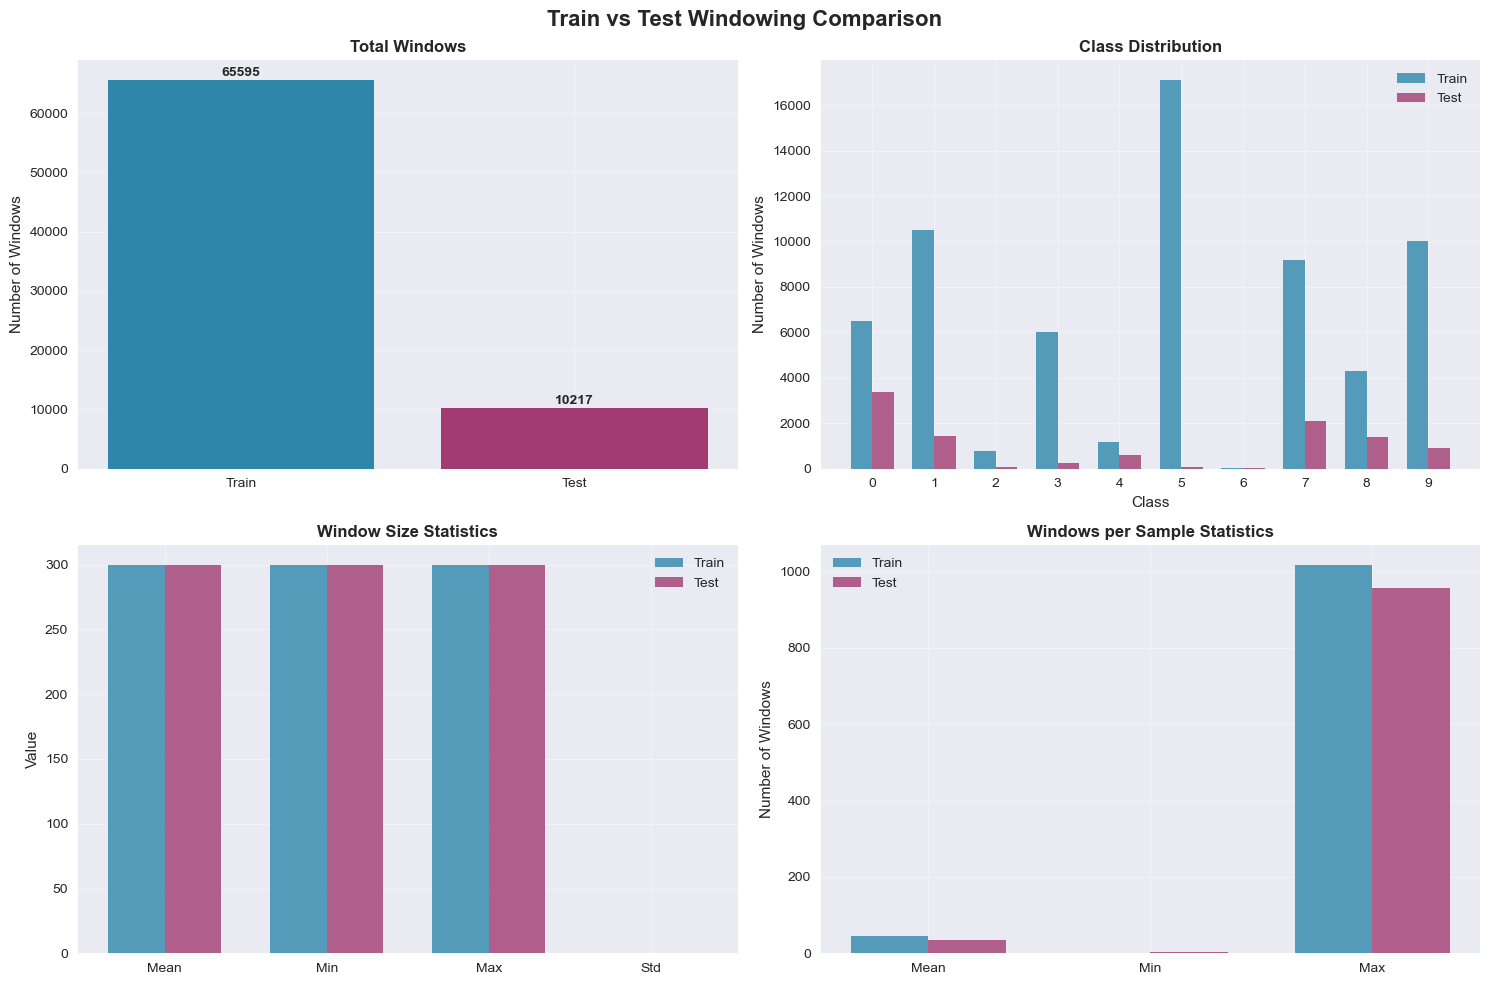

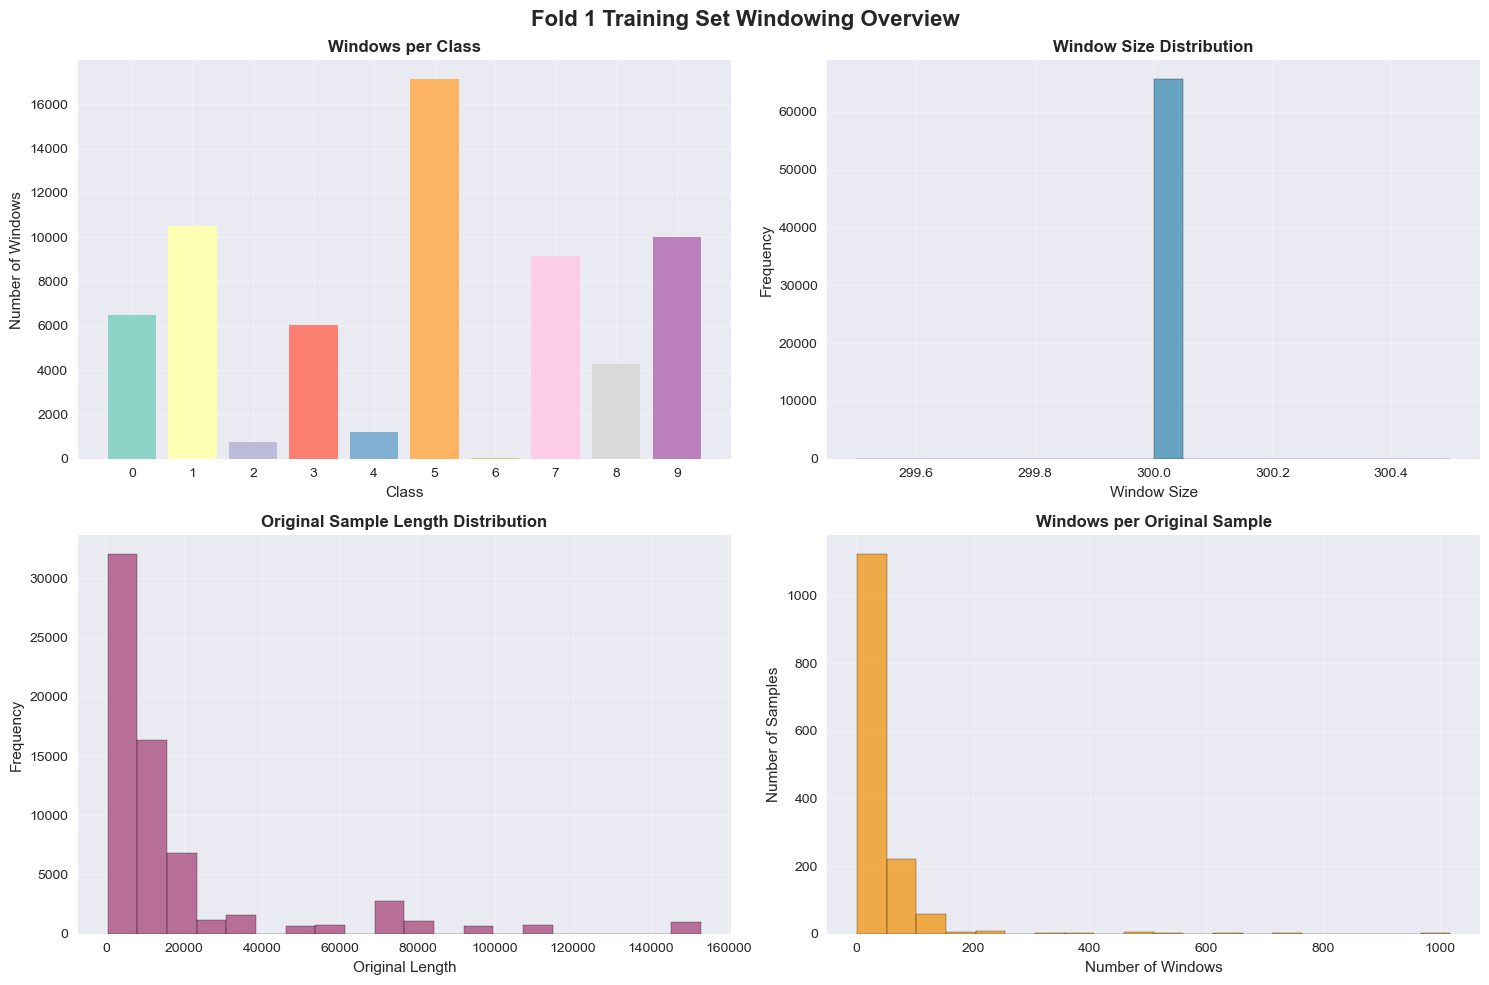


🔍 Showing window examples from Fold 1, training sample 1:
   Original sample length: 3575
   Number of windows created: 22
   Using config columns: P-TPT, T-TPT


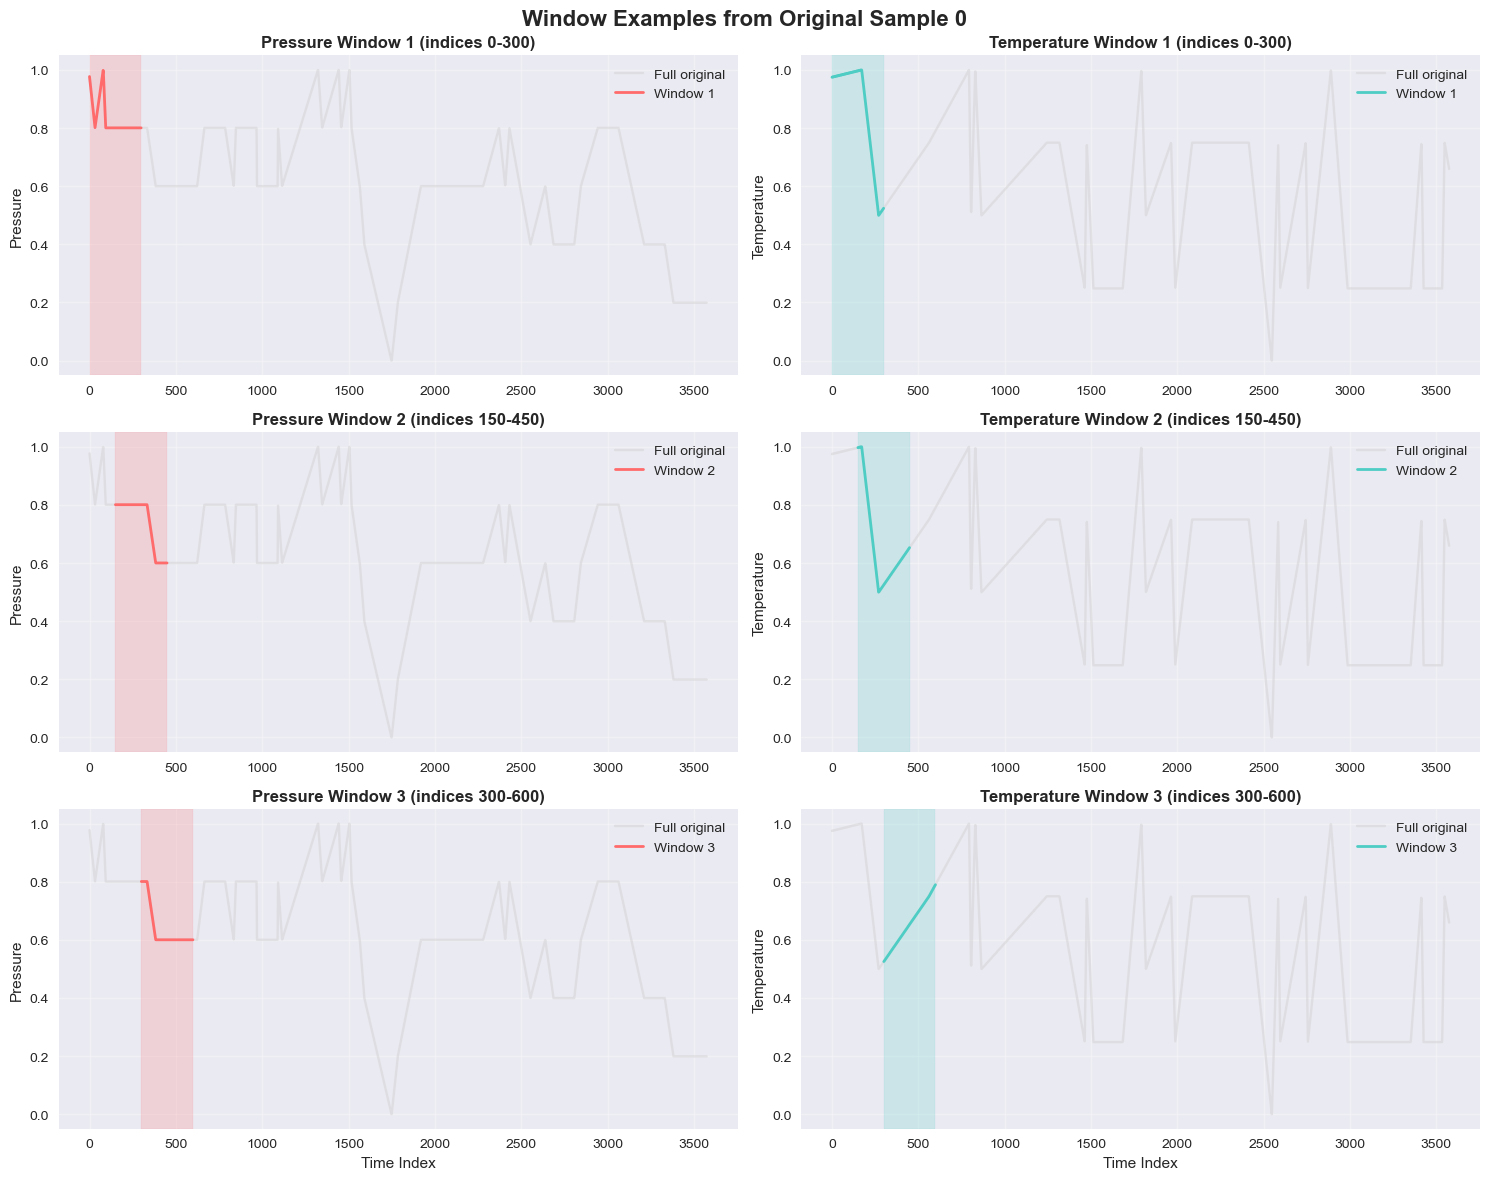


📊 Cross-Fold Windowing Summary:
   Fold 1: 65595 train windows, 10217 test windows
   Fold 2: 66516 train windows, 9296 test windows
   Fold 3: 65148 train windows, 10664 test windows

📈 Average per fold:
   • Training windows: 65753.0
   • Test windows: 10059.0


In [ ]:
# Visualize windowing results from Fold 1 (sample)
print("\n📈 Creating Windowing Visualizations (Fold 1 Sample)")
print("-" * config.SEPARATOR_LENGTH)

try:
    # Get Fold 1 data for visualization
    fold_1_data = all_windowed_folds[0]
    fold_1_windowing = fold_1_data["windowing_results"]

    # Plot windowing comparison between train and test for Fold 1
    visualizer.plot_windowing_comparison(
        fold_1_windowing["train_statistics"], fold_1_windowing["test_statistics"]
    )

    # Show windowing overview for Fold 1 training data (if metadata exists)
    fold_1_train_metadata = fold_1_windowing.get("train_metadata", [])
    if fold_1_train_metadata:
        visualizer.plot_windowing_overview(
            fold_1_train_metadata, "Fold 1 Training Set Windowing Overview"
        )
    else:
        print("ℹ️  No metadata available for detailed windowing overview")
        
    print("✅ Visualization complete")
    
except Exception as e:
    print(f"⚠️  Visualization error: {e}")
    print("Continuing without visualization...")

## Save Processed Data

Save cross-validation splits and windowed data for training notebooks.

In [ ]:
# ============================================================
# STEP 7: SAVE PROCESSED DATA FOR MODEL TRAINING
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 7: SAVE PROCESSED DATA FOR MODEL TRAINING")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# Create comprehensive results structure
extended_windowing_results = {
    "all_windowed_folds": all_windowed_folds,
    "total_train_windows": total_train_windows,
    "total_test_windows": total_test_windows,
    "window_config": {
        "window_size": window_size,
        "stride": stride,
        "min_window_size": min_window_size
    },
    "fold_count": len(cv_folds)
}

print(f"? Preparing to save:")
print(f"   • CV folds: {len(cv_folds)}")
print(f"   • Windowed folds: {len(all_windowed_folds)}")
print(f"   • Total windows: {total_train_windows + total_test_windows:,}")
print(f"   • Format: {config.SAVE_FORMAT}")
print(f"   • Directory: {config.PROCESSED_DATA_DIR}")

# Configure save directory
save_dir = config.PROCESSED_DATA_DIR
print(f"\n💾 Saving to: {save_dir}")

processing_config = {
    "sampling_rate": config.SAMPLING_RATE,
    "window_size": window_size,
    "stride": stride,
    "n_folds": config.N_FOLDS,
    "scaling_method": scaling_method,
    "save_format": config.SAVE_FORMAT,
    "processed_timestamp": str(pd.Timestamp.now())
}

STEP 7: SAVE PROCESSED DATA FOR TRAINING NOTEBOOKS
💾 Initializing Data Persistence System
--------------------------------------------------
⚠️ Missing required variables: ['cv_folds', 'all_windowed_folds']
   Please run the cross-validation and windowing steps first
   Continuing with available data...
📁 Save directory: processed_data
📋 Save format: pickle

📊 Data to be saved:
   • Cross-validation folds: 3
   • Windowed folds: 3
   • Total training windows: 197259
   • Total test windows: 30177


In [ ]:
processing_config

{'target_features': ['P-PDG', 'P-TPT', 'T-TPT', 'class'],
 'scaling_method': 'minmax',
 'n_folds': 3,
 'window_size': 300,
 'window_stride': 150,
 'min_window_size': 300,
 'random_seed': 42,
 'cv_random_state': 42,
 'pressure_column': 'P-TPT',
 'temperature_column': 'T-TPT',
 'class_column': 'class',
 'processing_notebook': 'Data Treatment.ipynb',
 'toolkit_version': '1.0.0',
 'windowing_applied_to_all_folds': True,
 'total_windowed_folds': 3,
 'total_train_windows': 197259,
 'total_test_windows': 30177}

In [ ]:
# ============================================================
# Execute Save Operation
# ============================================================
print("🔄 Saving processed data...")

try:
    # Re-import modules to ensure latest config
    import importlib
    import src.config
    import src.data_persistence
    
    importlib.reload(src.config)
    importlib.reload(src.data_persistence)
    from src.data_persistence import save_complete_pipeline
    from src import config

    # Save with optimized pickle format
    saved_dir = save_complete_pipeline(
        cv_folds=cv_folds,
        windowing_results=extended_windowing_results,
        processing_config=processing_config,
        base_dir=save_dir,
    )

    print(f"✅ Save successful!")
    print(f"📂 Location: {saved_dir}")
    
    # Quick summary
    from src.data_persistence import DataPersistence
    persistence = DataPersistence(base_dir=saved_dir, verbose=False)
    save_summary = persistence.get_save_summary()

    print(f"📊 Summary: {save_summary['total_files']} files, {save_summary['total_size_mb']:.1f} MB")
    print(f"🚀 Ready for model training!")

except Exception as e:
    print(f"❌ Save error: {e}")
    print("? Check config.SAVE_FORMAT and directory permissions")
    raise

🔄 Saving Data with Pickle Format for Fast Loading
⚡ Using format: pickle (for fastest loading)
📁 Save directory: processed_data
💾 Saving with pickle format for maximum speed...
📁 Created directory structure in: processed_data
💾 Saving Cross-Validation Folds
--------------------------------------------------
   📁 Fold 1:
      • Training: 1427 samples → processed_data\cv_splits\raw\fold_1\train_data.pickle
      • Testing: 287 samples → processed_data\cv_splits\raw\fold_1\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_1\fold_metadata.json
   📁 Fold 1:
      • Training: 1427 samples → processed_data\cv_splits\raw\fold_1\train_data.pickle
      • Testing: 287 samples → processed_data\cv_splits\raw\fold_1\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_1\fold_metadata.json
   📁 Fold 2:
      • Training: 1427 samples → processed_data\cv_splits\raw\fold_2\train_data.pickle
      • Testing: 287 samples → processed_data\cv_splits\raw\fold_2\test_data.

In [ ]:
# ============================================================
# FINAL SUMMARY
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("🎯 DATA TREATMENT PIPELINE COMPLETE!")
print("=" * config.HEADER_SEPARATOR_LENGTH)

print(f"✅ Successfully processed {len(normalized_dfs)} samples")
print(f"✅ Created {len(cv_folds)} cross-validation folds")
print(f"✅ Generated {total_train_windows + total_test_windows:,} windowed samples")
print(f"✅ Saved all data in {config.SAVE_FORMAT} format")

print(f"\n🚀 Ready for machine learning model training!")
print(f"📝 Next: Load the saved data in your training notebook")